ใน ep นี้

# 0. Install

เราจะต้อง Install kaggle เพื่อ Download Dataset

In [95]:
# Colab
! curl -s https://course.fast.ai/setup/colab | bash
! pip install kaggle --upgrade


Updating fastai...
Done.
Requirement already up-to-date: kaggle in /usr/local/lib/python3.6/dist-packages (1.5.6)


# 1. Import Library

Import Libray ที่เราต้องการใช้

In [0]:
import math
import numpy as np
import pandas as pd

from pathlib import Path
from matplotlib import cm
from matplotlib import pyplot as plt

import fastai
from fastai.vision import *

In [97]:
fastai.__version__

'1.0.59'

# 2. เตรียม Path สำหรับดาวน์โหลดข้อมูล

กำหนด path ของ Config File และ Dataset ว่าจะอยู่ใน Google Drive ถ้าเราใช้ [Google Colab](https://www.bualabs.com/archives/1687/what-is-colab-open-jupyter-notebook-in-github-on-google-colab-create-open-in-colab-button-colab-ep-1/) หรือ อยู่ใน HOME ถ้าเราใช้ VM ธรรมดา และกำหนด Environment Variable ไปยังโฟลเดอร์ที่เก็บ kaggle.json

ในกรณีใช้ Colab ให้ Mount Google Drive เพื่อดึง Config File มาจาก Google Drive ส่วนตัวของเรา เมื่อเรารัน Cell ด้านล่างจะมีลิงค์ปรากฎขึ้นมาให้เรา Login กด Approve แล้ว Copy Authorization Code มาใส่ในช่องด้านล่าง แล้วกด Enter

In [98]:
dataset = 'histopathologic-cancer-detection'

# Google Colab
config_path = Path('/content/drive')
data_path_base = Path('/content/datasets/')

data_path = data_path_base/dataset

from google.colab import drive
drive.mount(str(config_path))
os.environ['KAGGLE_CONFIG_DIR'] = f"{config_path}/My Drive/.kaggle"

# # VM
# config_path = Path(os.getenv("HOME"))
# data_path = config_path/"datasets"/dataset

# data_path.mkdir(parents=True, exist_ok=True)
# os.environ['KAGGLE_CONFIG_DIR'] = f"{config_path}/.kaggle"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 3. Dataset

ในเคสนี้ เราจะ Download ข้อมูล Dataset ที่เกี่ยวข้องทั้งหมดมาเก็บไว้ แบ่งเป็นรูปฟิล์ม X-Ray ขนาดต่าง ๆ ข้อมูลต้นฉบับ ข้อมูล Test Set, etc.

Dataset เราจะดึงจาก Kaggle วิธี Download kaggle.json ให้ดูจาก ep ที่แล้ว

เมื่อได้ kaggle.json มาแล้ว ในกรณีใช้ Google Colab ให้นำมาใส่ไว้ในโฟลเดอร์ My Drive/.kaggle ใน Google Drive ของเรา เป็น My Drive/.kaggle/kaggle.json ถ้าใช้ VM ให้ใส่ใน HOME/.kaggle/

สั่งดาวน์โหลด Dataset จาก Kaggle พร้อมทั้ง unzip ไว้ใน data_path

In [99]:
!kaggle competitions download -c {dataset} -p "{data_path}"

sample_submission.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
train_labels.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
test.zip: Skipping, found more recently modified local copy (use --force to force download)
train.zip: Skipping, found more recently modified local copy (use --force to force download)


Unzip ไฟล์ที่ดาวน์โหลดจาก Kaggle Competition

In [0]:
! unzip -q {data_path}/train.zip -d {data_path}/train
! unzip -q {data_path}/test.zip -d {data_path}/test
! unzip -q {data_path}/sample_submission.csv.zip -d {data_path}
! unzip -q {data_path}/train_labels.csv.zip -d {data_path}

# 4. Data

In [100]:
data_path.ls()

[PosixPath('/content/datasets/histopathologic-cancer-detection/test'),
 PosixPath('/content/datasets/histopathologic-cancer-detection/train.zip'),
 PosixPath('/content/datasets/histopathologic-cancer-detection/train_labels.csv.zip'),
 PosixPath('/content/datasets/histopathologic-cancer-detection/train'),
 PosixPath('/content/datasets/histopathologic-cancer-detection/sample_submission.csv.zip'),
 PosixPath('/content/datasets/histopathologic-cancer-detection/train_labels.csv'),
 PosixPath('/content/datasets/histopathologic-cancer-detection/sample_submission.csv'),
 PosixPath('/content/datasets/histopathologic-cancer-detection/test.zip')]

In [101]:
(data_path/'train').ls()[:5]

[PosixPath('/content/datasets/histopathologic-cancer-detection/train/973f41e6e2d187c6226fa86e7486d58bd577cf77.tif'),
 PosixPath('/content/datasets/histopathologic-cancer-detection/train/c76ec3825c8301931dbaf813fb24daa5182fc09e.tif'),
 PosixPath('/content/datasets/histopathologic-cancer-detection/train/7e968c7e36bcf68efb00ad65178df5c114ca6bc9.tif'),
 PosixPath('/content/datasets/histopathologic-cancer-detection/train/623ac4c155c6bb09c7247d8f27a33e490f32f01d.tif'),
 PosixPath('/content/datasets/histopathologic-cancer-detection/train/8a6827cfba13f3a275b53d25e5b73fec3847d871.tif')]

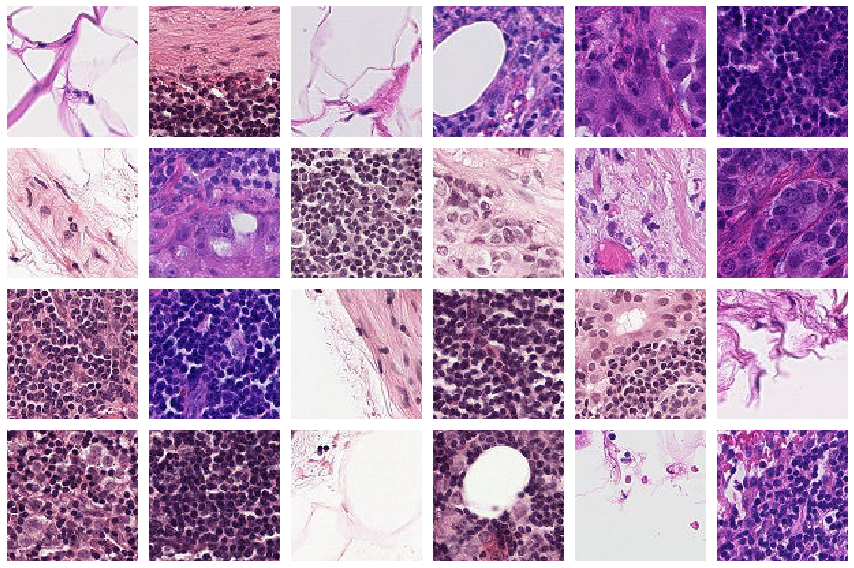

In [202]:
fig, axes = plt.subplots(4, 6, figsize=(12, 8))
for ax, f in zip(axes.flatten(), (data_path/'train').ls()[:24]):
    ax.imshow(PIL.Image.open(f), origin='lower')
    ax.axis('off')
plt.tight_layout()

# 5. Data Pipeline

In [0]:
bs = 128
SZ = 90
path = data_path

In [0]:
tfms = get_transforms(flip_vert=True)

In [154]:
df =  pd.read_csv(data_path/'train_labels.csv')
df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


ใช้ [DataBlock API](https://www.bualabs.com/archives/2693/data-block-api-data-pipeline-machine-learning-supervised-learning-preprocessing-ep-5/) สร้าง [DataBunch](https://www.bualabs.com/archives/2318/databunch-learner-refactor-neural-network-training-loop-neural-network-ep-9/) เตรียมส่งให้ Model สำหรับเทรน โดย [Train/Validation Split](https://www.bualabs.com/archives/532/what-is-training-set-why-train-test-split-training-set-validation-set-test-set/) 80/20, Label เป็น Binary Classification 0/1 , ทำ [Data Augmentation](https://www.bualabs.com/archives/1170/what-is-data-augmentation-benefits-data-augmentaion-deep-learning-training-model-deep-neural-network-regularization-ep-1/) รวมถึง Flip Vertical แล้ว [Normalize](https://www.bualabs.com/archives/2100/what-is-normalization-feature-scaling-rescaling-normalization-standardization-feedforward-train-machine-learning-preprocessing-ep-2/) ด้วย imagenet_stats

In [0]:
# Create databunch
data = (ImageList.from_df(path=path/'train', df=df, suffix='.tif')#[:500]
        .split_by_rand_pct(0.2, seed=1234)
        .label_from_df(cols='label')
        .add_test((path/'test').ls(), label=None)
        .transform(tfms, size=SZ)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

ได้ Traing Set และ Validation Set จำนวนดังนี้

In [204]:
len(data.train_ds), len(data.valid_ds)

(176020, 44005)

ดูข้อมูล 1 Batch 

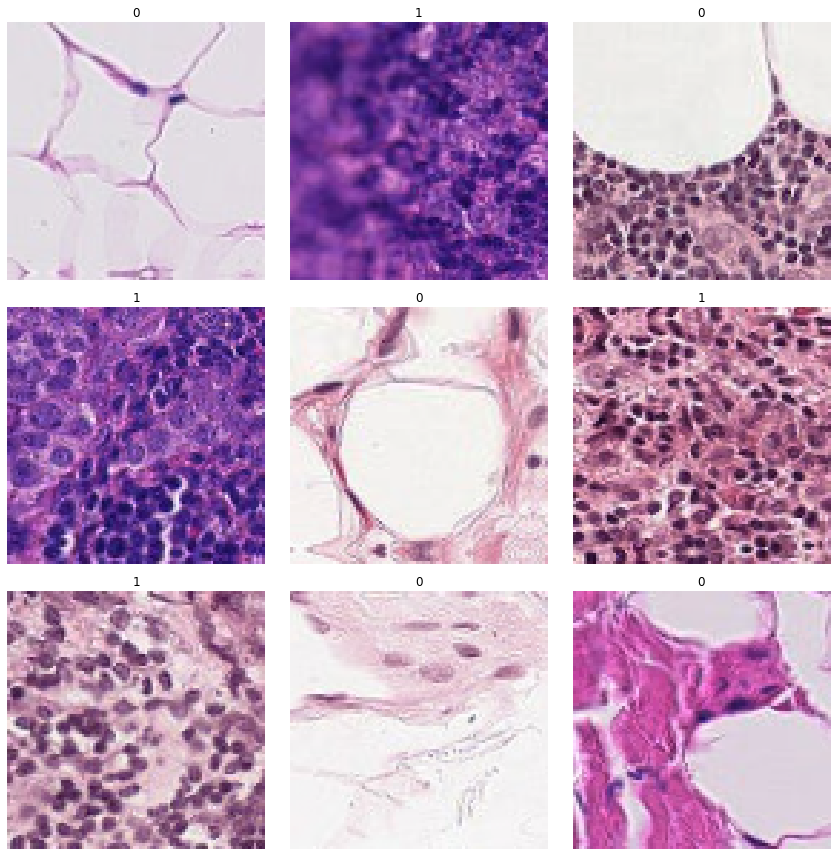

In [205]:
data.show_batch(rows=3, figsize=(12, 12))

# 6. Model

เราจะใช้ [Model Architecture](https://www.bualabs.com/archives/2703/how-to-read-model-convolutional-neural-network-shape-activation-map-model-architecture-convnet-ep-7/) เหมือน ep ที่แล้ว ResNet34 แปลงโมเดลเป็นแบบ Mixed Precision Training

In [0]:
learn = cnn_learner(data, models.resnet34, metrics=[accuracy, AUROC()],
                    wd=1e-1, callback_fns=ShowGraph).to_fp16()

In [0]:
# learn.summary()

# 7. Train

In [0]:
# learn.lr_find()
# learn.recorder.plot(suggestion=True, skip_last=1)

## 7.1 Train Last Layer

In [0]:
lr = 3e-2

epoch,train_loss,valid_loss,accuracy,auroc,time
0,0.333807,0.492760,0.768004,0.939774,10:02
1,0.286516,0.392294,0.838518,0.922742,10:05
2,0.237596,0.203793,0.920623,0.971999,10:08


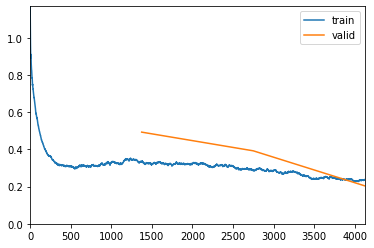

In [178]:
learn.fit_one_cycle(3, max_lr=lr)

In [0]:
learn.save('01g-resnet34-1')

In [0]:
learn.load('01g-resnet34-1');

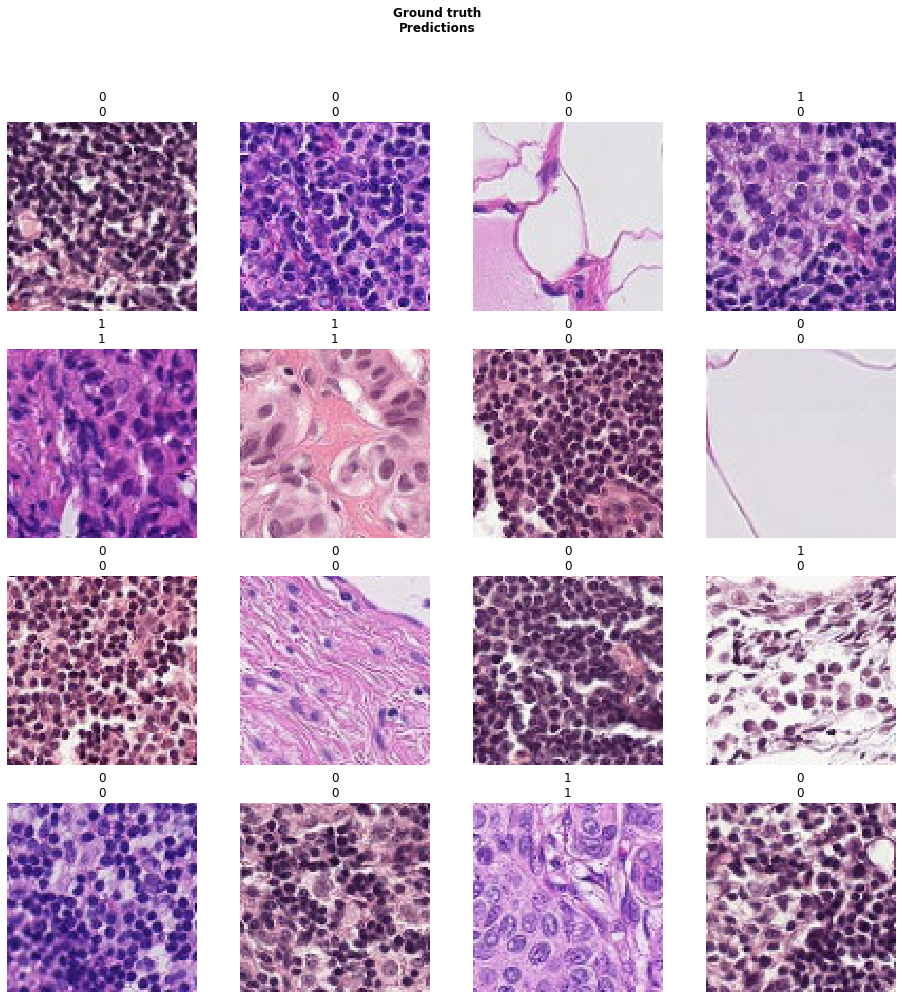

In [181]:
learn.show_results(rows=4, figsize=(16, 16))

## 7.2 Unfreeze and Train Whole Model

In [0]:
learn.unfreeze()

In [0]:
# learn.lr_find()
# learn.recorder.plot(suggestion=True, skip_last=0)

In [0]:
lr = slice(3e-6, 1e-2)

epoch,train_loss,valid_loss,accuracy,auroc,time
0,0.230112,0.201937,0.921918,0.972485,10:42
1,0.219460,0.199972,0.923850,0.972735,10:38
2,0.231962,0.190348,0.927258,0.975839,10:41
3,0.221292,0.185931,0.930099,0.976911,10:39
4,0.202917,0.176078,0.932258,0.978932,10:35
5,0.199276,0.170469,0.935326,0.980502,10:43
6,0.196302,0.168108,0.936007,0.981029,10:44
7,0.188333,0.165582,0.936984,0.981418,10:45
8,0.192865,0.164592,0.937893,0.981668,10:45


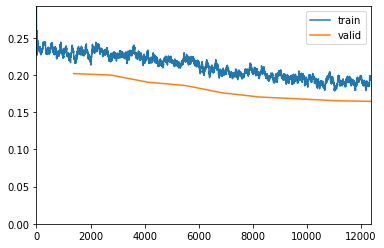

In [185]:
learn.fit_one_cycle(9, max_lr=lr)

In [0]:
learn.save('01g-resnet34-2')

In [0]:
learn.load('01g-resnet34-2');

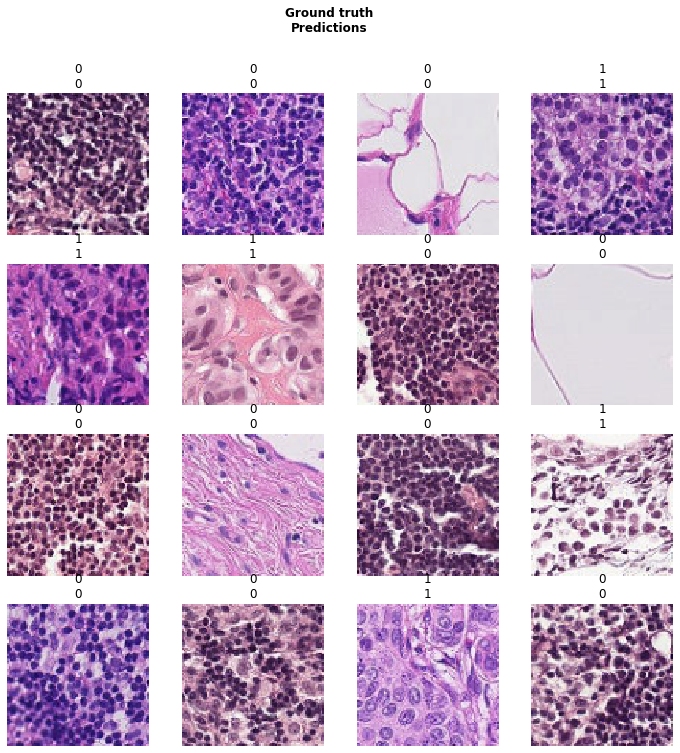

In [188]:
learn.show_results(rows=4, figsize=(12, 12))

## 7.7 Data Augmentation Annealing

ก่อน Infer เราจะเทรนด้วยข้อมูลที่ไม่ได้ทำ [Data Augmentation](https://www.bualabs.com/archives/1170/what-is-data-augmentation-benefits-data-augmentaion-deep-learning-training-model-deep-neural-network-regularization-ep-1/) ตบท้าย

In [221]:
learn.destroy()
gc.collect()

this Learner object self-destroyed - it still exists, but no longer usable


0

In [0]:
bs = 128

SZ = 96
path = data_path

In [0]:
transform_none = [[], []]
# Create databunch
data = (ImageList.from_df(path=path/'train', df=df, suffix='.tif')#[:500]
        .split_by_rand_pct(0.01, seed=1234)
        .label_from_df(cols='label')
        .add_test((path/'test').ls(), label=None)
        .transform(transform_none, size=SZ)
        .databunch(bs=bs)
        .normalize())

In [0]:
learn = cnn_learner(data, models.resnet34, metrics=[accuracy, AUROC()],
                    wd=1e-1, callback_fns=ShowGraph).to_fp16()

In [0]:
learn.load('01g-resnet34-2');

In [0]:
learn.freeze()

In [0]:
# learn.lr_find()
# learn.recorder.plot(suggestion=True, skip_last=1)

In [0]:
lr = slice(3e-2)

epoch,train_loss,valid_loss,accuracy,auroc,time
0,0.199856,0.239382,0.915455,0.979219,07:25
1,0.156813,0.138708,0.944545,0.986504,07:12


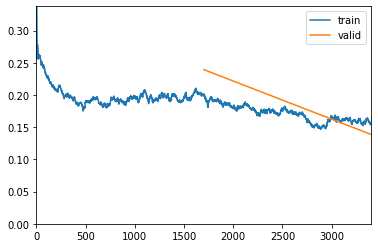

In [229]:
learn.fit_one_cycle(2, max_lr=lr)

In [0]:
learn.unfreeze()

In [0]:
# learn.lr_find()
# learn.recorder.plot(suggestion=True, skip_last=1)

In [0]:
lr = slice(3e-6, 3e-3)

epoch,train_loss,valid_loss,accuracy,auroc,time
0,0.158083,0.145681,0.943182,0.985654,07:44
1,0.144241,0.144040,0.943182,0.986508,07:44
2,0.133836,0.123079,0.955000,0.989277,07:39
3,0.122626,0.120382,0.956364,0.989790,07:42


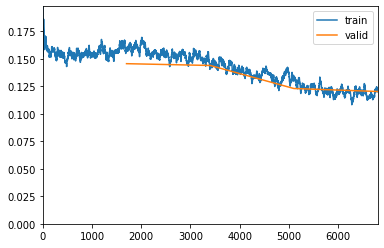

In [233]:
learn.fit_one_cycle(4, max_lr=lr)

In [0]:
learn.save('01g-resnet34-3')

In [0]:
learn.load('01g-resnet34-3');

In [0]:
# learn.show_results(rows=4, figsize=(16, 16))

In [0]:
interpretation = ClassificationInterpretation.from_learner(learn)

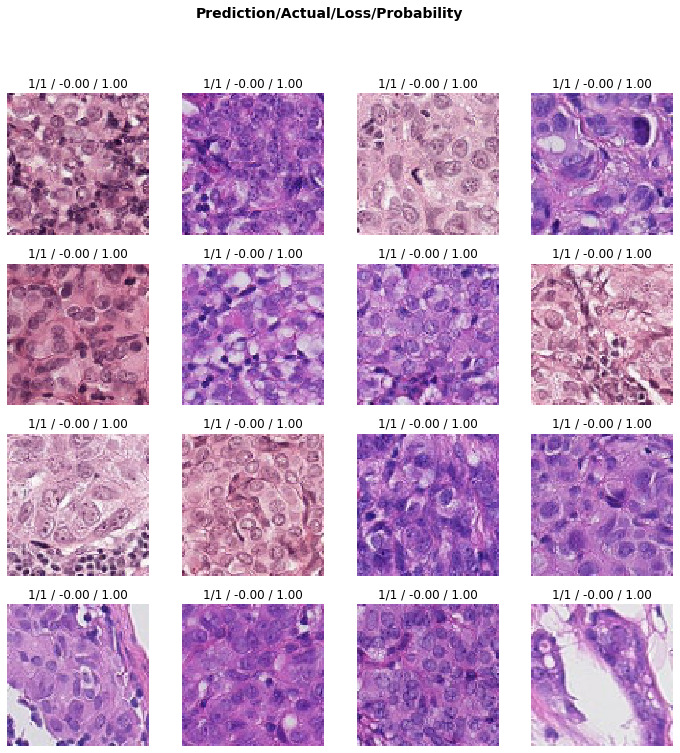

In [238]:
interpretation.plot_top_losses(16, figsize=(12,12), heatmap=True, largest=False)

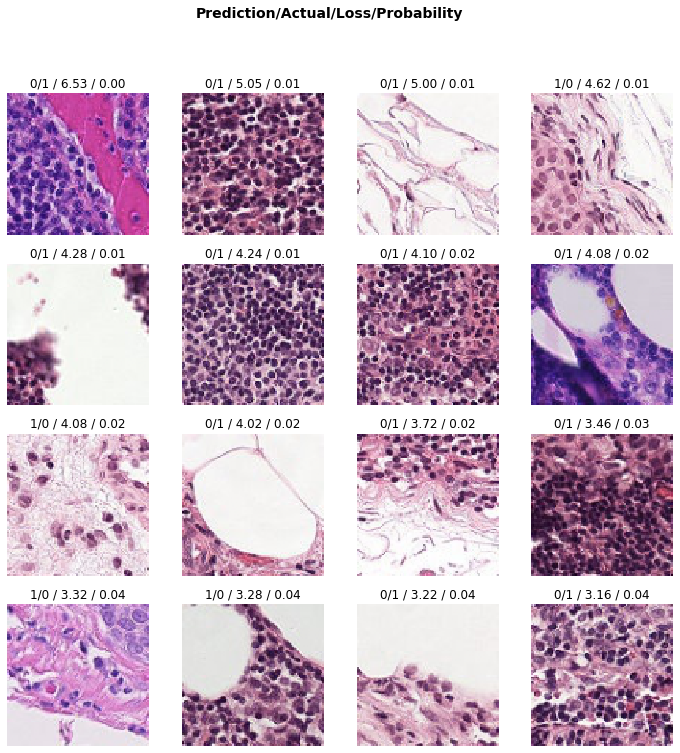

In [239]:
interpretation.plot_top_losses(16, figsize=(12,12), heatmap=False, largest=True)

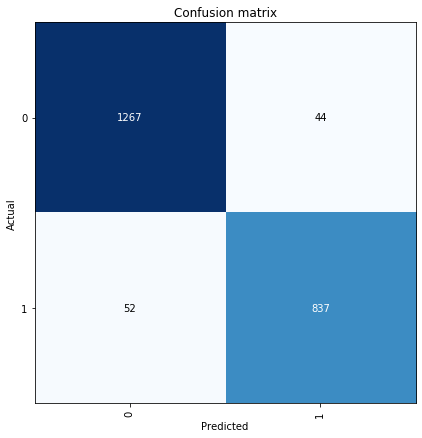

In [240]:
interpretation.plot_confusion_matrix(figsize=(6,6), dpi=72)

# 9. Submit Predictions to Kaggle

ส่งผลการวินิจฉัยข้อมูลตัวอย่าง ใน Test Set ไปให้ Kaggle ตรวจ

In [0]:
# Predictions for test set
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

In [242]:
preds[:10].argmax(axis=1)

tensor([0, 1, 0, 0, 1, 0, 0, 1, 0, 1])

แปลงเป็น DataFrame

In [243]:
ids = [o.stem for o in data.test_ds.items]
sub_df = pd.DataFrame({'id': ids, 'label': preds.argmax(axis=1)})
sub_df.head()

,id,label
0,92c82bcf1b7847828096e9d20f68452d54956a00,0
1,3db0939fc2b02b4408d45a7ce3cda03da1f74135,1
2,bee7099551b0fe6fc8ea95397928ea9c269876de,0
3,990db00173b8cd4bae84047a51001770d04a5144,0
4,5a8268427d28d76fe1805e31b6d32e2aaccb2a9f,1


In [244]:
sub_df.shape

(57458, 2)

In [0]:
sub_df.to_csv('submission.csv', index=False)

In [246]:
! kaggle competitions submit {dataset} -f {'submission.csv'} -m "Train full dataset with ResNet34 finish with data augmentation annealing"

100% 2.36M/2.36M [00:04<00:00, 565kB/s]
Successfully submitted to Histopathologic Cancer Detection



| Name           | Submitted    | Wait time | Execution time | Score   |
|----------------|--------------|-----------|----------------|---------|
| submission.csv | a day ago    | 0 seconds | 1 seconds      | x  |


เราได้ Public Leaderboard x, Private Leaderboard x อยู่ที่อันดับ x จาก 1,157 team ดังตารางด้านล่าง = Top x%

| #   	| Team Name      	| Score  	| Last 	|
|-----	|----------------	|--------	|------	|
| 278 	| UWRad          	| 0.8113 	| 2mo  	|
| 279 	| Mitul          	| 0.8105 	| 2mo  	|
| 280 	| diCELLa        	| 0.8096 	| 2mo  	|
| 281 	| lucaskg        	| 0.8094 	| 2mo  	|
| 282 	| Insaf Ashrapov 	| 0.8091 	| 2mo  	|



Top 10 ใน Private Leaderboard คือ อันดับที่ 115 จาก 1157 ทีม Score = 0.9738

# สรุป

* เราได้สร้าง AI วิจิฉัย x ที่ทำงานได้อย่าง อย่างแม่นยำพอสมควร ด้วยการเทรนโมเดล ด้วย GPU ไม่ถึง 3 ชั่วโมง
* เราสามารถเพิ่มความซับซ้อนของโมเดล, รูปขนาดใหญ่ขึ้น, Loss Function, Multi-Head และใช้ GPU รุ่นใหม่ขึ้นในการเทรน ให้ได้ผลลัพธ์ที่แม่นยำมากขึ้น รวดเร็วขึ้นไปอีก
* เราสามารถประยุกต์ใช้โมเดลนี้ กับโรคที่คล้าย ๆ กันอีกหลายโรค ที่ต้องวินิจฉัยโดย x

# Credit

* https://www.kaggle.com/c/histopathologic-cancer-detection
* https://www.bualabs.com/archives/2856/ai-diagnose-pneumothorax-read-chest-x-ray-radiograph-image-collapsed-lung-radiologist-triage-patient-classification-segment-medical-image-segmentation-ep-2/
* https://www.bualabs.com/archives/530/machine-learning-ai-skin-disease-classification-custom-dataset-how-to-build-model-resnet50-deep-learning-python-image-classification-ep-4/

